In [370]:
import matplotlib.pylab as plt
import numba

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [403]:
import time_profiler

ImportError: No module named 'time_profiler'

In [30]:
import Estimation as st
import tables as tb
from Histogram import Histogram as hist
from PDF import PDF
from Utils import IsotopeDic, PartDic
from scipy.stats import poisson
import scipy.optimize as sop
import numpy as np
from scipy.special import gamma
from Fits import Fit

In [405]:
# %load ../Code/Fits.py
import Estimation as st
from Histogram import Histogram as hist
from PDF import PDF
from Utils import IsotopeDic, PartDic
from scipy.stats import poisson
import matplotlib.pylab as plt
import scipy.optimize as sop
import numpy as np
from scipy.special import gammaln
from copy import copy

def generalLogPoisson(x,mu):
    return -mu+x*np.log(mu+0.001)-gammaln(x+1)


class Fit():
    '''
    Class meant to perform the fit
    '''
    def __init__(self, E, spectrum, PDFs):
        '''
        E: x range (np array)
        spectrum: experimental points
        PDF: list of spectra PDFs
        nevs: normalizations for the spectra (they are the
            initial values for the fit)
        '''
        self.E = E[:]
        self.Ep = np.linspace(0.5,2.8,100)
        self.spectrum = spectrum.hist[:]
        for i in PDFs:
            print(i.Int)
        self.PDFs = copy(PDFs)#[pdf.Scale(1./pdf.Int) for pdf in PDFs]
        for i in PDFs:
            print(i.Int)
    #@numba.autojit
    def LogLikelihood(self, nevs):
        '''
        function meant to compute the LogLikelihood
        '''
        #print(self.PDFs,nevs)
        for i in nevs:
            if i<0.: return 1e12
        ypdf = np.array([sum([n*pdfi.pdf(Ei) for pdfi,n in zip(self.PDFs,nevs)]) for Ei in self.E])
        ydat = self.spectrum
        #print(type(ydat))
        #print(type(ypdf))
        lm = (np.array(generalLogPoisson(ydat,ypdf))).sum()
        
        return -lm
    #@numba.autojit
    def LikelihoodScan(self,var):
        nevsa = self.resx[:]
        nevsa[self.i] = var
        
        return self.LogLikelihood(nevsa)-self.LogLikelihood(self.resx)-2.
    
    def LikelihoodErrors(self,res):
        aux = []
        for i in range(len(res.x)):
            fun = self.LikelihoodScan
            self.resx = res.x
            self.i = i
            #lambda x: self.LogLikelihood(res.x[:i].reshape(res.x[:i].size)+np.array([x]).reshape(1) + res.x[i+1:].reshape(res.x[i+1:].size))-res.fun+2
            aux.append(sop.root(fun,[res.x[i]]))
        return aux    
        
        
    def FitLLM(self,nevs, **kwargs):
        nevs = np.array(nevs)
        nevs[-1]=0.
        fit = self.LogLikelihood
        res = sop.minimize(fit,nevs,method='Nelder-Mead',**kwargs)
        ypdf = np.array([sum([n*pdfi.pdf(Ei) for pdfi,n in zip(self.PDFs,res.x)]) for Ei in self.E])

        ydat = self.spectrum

        plt.plot(self.E,ypdf)
        plt.plot(self.E,ydat,'+')
        plt.semilogy()
        plt.ylim([1e-1,3e3])
        chi2 = -1
        if (res.success):
            chi2 = np.sum((ypdf-ydat)**2)/(1.*(len(ypdf)-len(nevs)))
        res.chi2 = chi2
        return res

    def LeastSQ(self,nevs):
        ypdf = np.array([sum([n*pdfi.pdf(Ei) for pdfi,n in zip(self.PDFs,nevs)]) for Ei in self.E])
        ydat = self.spectrum
        return np.power(ypdf-ydat,2).sum()

    def FitLeastSQ(self,nevs,**kwargs):
        nevs = np.array(nevs)
        fit = self.LeastSQ
        res = sop.minimize(fit,nevs,method='Nelder-Mead',**kwargs)
        ypdf = np.array([sum([n*pdfi.pdf(Ei) for pdfi,n in zip(self.PDFs,res.x)]) for Ei in self.E])
        ydat = self.spectrum
        chi2 = -1
        plt.plot(self.E,ypdf)
        plt.plot(self.E,ydat,'+')
        plt.semilogy()
        plt.ylim([1e-1,3e3])        
        if (res.success):
            chi2 = np.sum((ypdf-ydat)**2)/(1.*(len(ypdf)-len(nevs)))
        res.chi2 = chi2
        return res


In [18]:
f = tb.open_file("../Data/data_spectrum.h5", "r")

In [19]:
f

File(filename=../Data/data_spectrum.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Bi (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/Co (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/E (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/K (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/Tl (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/bb2n (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  b

In [67]:
minE,maxE,nbin = 0.6,3.,125
E = f.root.E[:]
Co = f.root.Co[:]
K = f.root.K[:]
Tl = f.root.Tl[:]
Bi = f.root.Bi[:]
bb2n = f.root.bb2n[:]
testnn = f.root.testnn[:]
total = f.root.total[:]

In [21]:
h_Co = hist([],nbin,minE,maxE)
h_Co.hist = Co
h_Co.bins = E
h_K = hist([], nbin,minE,maxE)
h_K.hist = K
h_K.bins = E
h_Tl = hist([],nbin,minE,maxE)
h_Tl.hist = Tl
h_Tl.bins = E
h_Bi = hist([],nbin,minE,maxE)
h_Bi.hist = Bi
h_Bi.bins = E
h_bb2n = hist([],nbin,minE,maxE)
h_bb2n.hist = bb2n
h_bb2n.bins = E
h_testnn = hist(testnn,nbin,minE,maxE)
h_testnn.hist = testnn
h_testnn.bins = E
h_total = hist(total,nbin,minE,maxE)
h_total.hist = total
h_total.bins = E

In [200]:
interpol = 'nearest'
pdf_Co = PDF(h_Co,interpolation=interpol)
pdf_K = PDF(h_K,interpolation=interpol)
pdf_Tl = PDF(h_Tl,interpolation=interpol)
pdf_Bi = PDF(h_Bi,interpolation=interpol)
pdf_bb2n = PDF(h_bb2n,interpolation=interpol)
pdf_testnn = PDF(h_testnn,interpolation=interpol)
pdf_total = PDF(h_total,interpolation=interpol)

In [201]:
pdflis = [pdf_Co,pdf_K,pdf_Tl,pdf_Bi,pdf_bb2n]
nevslist = np.array([150000,80000,1500,4000,2000])/8.

In [407]:
fit = Fit(E,h_total,pdflis)

0.024
0.024
0.024
0.024
0.024
0.024
0.024
0.024
0.024
0.024


CPU times: user 35.4 s, sys: 510 ms, total: 35.9 s
Wall time: 35.4 s


          chi2: 406.46389827446927
 final_simplex: (array([[ 18395.02975447,  10041.5398816 ,   1992.53178756,   4839.01641257,
          1384.7787113 ],
       [ 18395.02975447,  10041.5398816 ,   1992.53178756,   4839.01641257,
          1384.77871131],
       [ 18395.02975448,  10041.5398816 ,   1992.53178756,   4839.01641257,
          1384.7787113 ],
       [ 18395.02975447,  10041.5398816 ,   1992.53178756,   4839.01641257,
          1384.77871131],
       [ 18395.02975448,  10041.5398816 ,   1992.53178756,   4839.01641256,
          1384.7787113 ],
       [ 18395.02975448,  10041.5398816 ,   1992.53178756,   4839.01641256,
          1384.7787113 ]]), array([ 357.46490713,  357.46490713,  357.46490713,  357.46490713,
        357.46490713,  357.46490713]))
           fun: 357.46490713125877
       message: 'Optimization terminated successfully.'
          nfev: 1091
           nit: 633
        status: 0
       success: True
             x: array([ 18395.02975447,  10041.5398816 , 

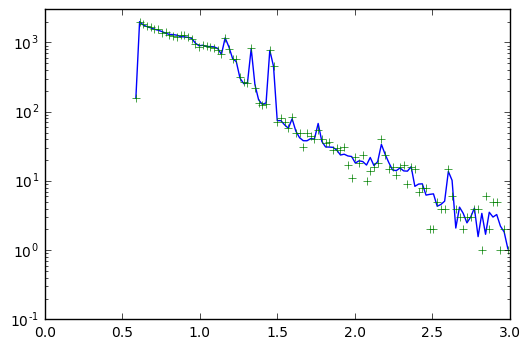

In [406]:
%time fit.FitLLM(nevslist,tol=1e-8,options={"maxiter":1000})

CPU times: user 28.8 s, sys: 304 ms, total: 29.1 s
Wall time: 28.8 s


          chi2: 388.08731283564168
 final_simplex: (array([[ 18967.83852213,  10149.60059752,   2634.76098586,   4478.62764799,
           540.68232899],
       [ 18967.83852213,  10149.60059752,   2634.76098586,   4478.62764799,
           540.68232899],
       [ 18967.83852213,  10149.60059752,   2634.76098586,   4478.62764799,
           540.68232898],
       [ 18967.83852213,  10149.60059753,   2634.76098587,   4478.62764799,
           540.68232898],
       [ 18967.83852213,  10149.60059752,   2634.76098586,   4478.62764799,
           540.68232899],
       [ 18967.83852213,  10149.60059752,   2634.76098586,   4478.62764798,
           540.68232899]]), array([ 46570.47754028,  46570.47754028,  46570.47754028,  46570.47754028,
        46570.47754028,  46570.47754028]))
           fun: 46570.477540277003
       message: 'Optimization terminated successfully.'
          nfev: 1112
           nit: 658
        status: 0
       success: True
             x: array([ 18967.83852213,  1014

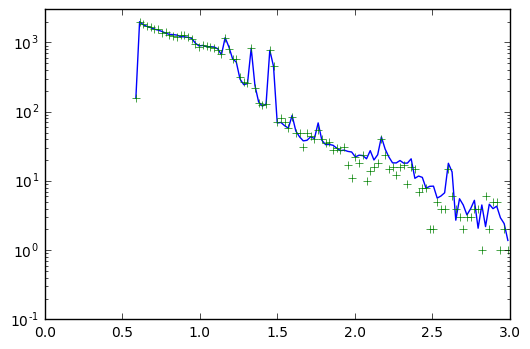

In [204]:
%time fit.FitLeastSQ(nevslist,tol=1e-8,options={"maxiter":1000})

In [ ]:
y_Co = pdf_Co.
pdf_K = PDF(h_K,interpolation='linear')
pdf_Tl = PDF(h_Tl,interpolation='linear')
pdf_Bi = PDF(h_Bi,interpolation='linear')
pdf_bb2n = PDF(h_bb2n,interpolation='linear')
pdf_testnn = PDF(h_testnn,interpolation='linear')
pdf_total = PDF(h_total,interpolation='linear')

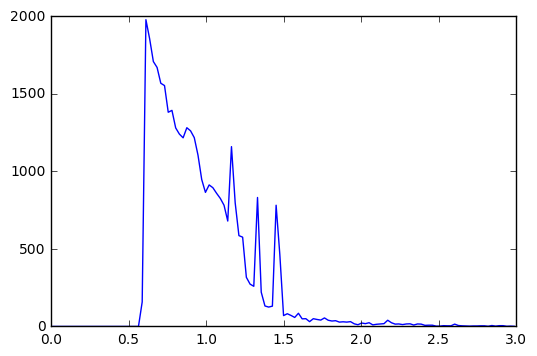

In [26]:
plt.plot(h_total.bins,h_total.hist)

In [ ]:
h_total.hist

In [ ]:
total.sum()

In [ ]:
plt.plot(E,pdf_Co.pdf(E))

# 

In [ ]:
z

In [43]:
q = [h_Co, h_K, h_Tl, h_Bi, h_bb2n]
for i in q:
    print(i.hist.sum())

148976.0
79596.0
15221.0
38295.0
11421.0


In [46]:
([ 18395.0299483 ,  10041.53976801,   1992.53166339,   4839.01642561,
         1384.77856453])

[18395.0299483, 10041.53976801, 1992.53166339, 4839.01642561, 1384.77856453]

In [45]:
([ 18967.83846797,  10149.60050587,   2634.76089284,   4478.6276829 ,
          540.68255758])

[18967.83846797, 10149.60050587, 2634.76089284, 4478.6276829, 540.68255758]

In [47]:
d = np.array([ 18395.0299483 ,  10041.53976801,   1992.53166339,   4839.01642561,
         1384.77856453])
d**0.5

array([ 135.62827857,  100.20748359,   44.63778291,   69.56303922,
         37.21261298])

In [54]:
((np.array([ 18395.0299483 ,  10041.53976801,   1992.53166339,   4839.01642561,
         1384.77856453]) - np.array([148976.0,79596.0,15221.0,38295.0,11421.0])/8.)**2)**0.5

array([ 226.9700517 ,   92.03976801,   89.90666339,   52.14142561,
         42.84643547])

# Errors

In [386]:
aux =fit.LogLikelihood

In [387]:
def do(aux):
    for i in range(100):
        aux([i]*5)
do(aux)

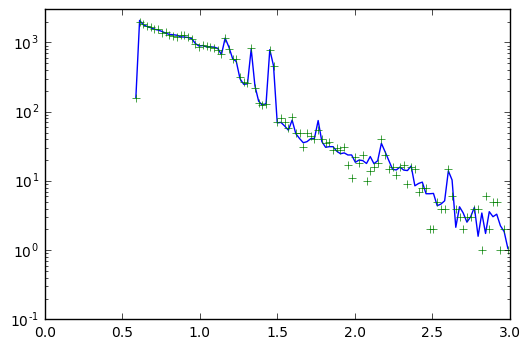

In [408]:
res = fit.FitLLM(nevslist,tol=1e-8,options={"maxiter":1000})

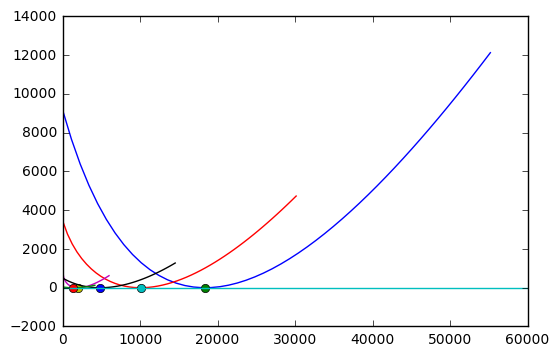

In [365]:
N = 50
for i in range(5):
    nevs = np.copy(result)
    x = np.linspace(0,result[i]*3,N)
    y = np.zeros([N,1])
    for event in range(len(x)):
        nevs[i] = x[event]
        y[event] = fit.LogLikelihood(nevs)
    plt.plot(x,y-357.46490713137422-2)
    plt.plot(result[i],fit.LogLikelihood(result)-357.46490713137422-2,'o')
plt.plot([0,60000],[0,0])

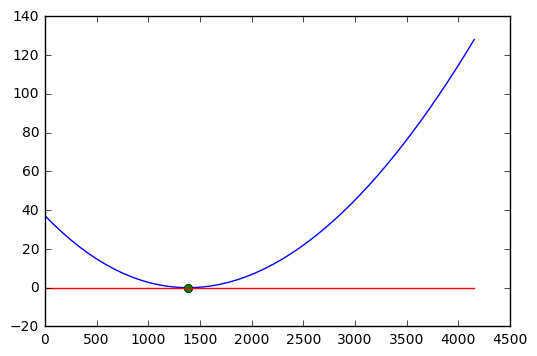

In [404]:
plt.plot(x,y-357.46490713137422)
plt.plot(result[i],fit.LogLikelihood(result)-357.46490713137422,'o')
plt.plot([x[0],x[-1]],[0,0])
#for i in 

In [346]:
x = np.linspace(0,result[i]*3,1000)

In [348]:
result

array([   0.        ,  304.28908732,  120.75950228,  439.91058296,
        167.85196501])

In [ ]:
357.46490713125877 -


# Plot

In [353]:
result = np.array([18395.02975447, 10041.5398816, 1992.53178756, 4839.01641257, 1384.7787113])

In [121]:
interpol = 'nearest'
pdf_CoP = PDF(h_Co,factor=result[0],interpolation=interpol)
pdf_KP = PDF(h_K,factor=result[1],interpolation=interpol)
pdf_TlP = PDF(h_Tl,factor=result[2],interpolation=interpol)
pdf_BiP = PDF(h_Bi,factor=result[3],interpolation=interpol)
pdf_bb2nP = PDF(h_bb2n,factor=result[4],interpolation=interpol)



In [143]:
Ep = np.linspace(0.6,2.8,1000)
aux =(E>0.6)&(E<2.8)
Ea = E[aux]
totala = total[aux]
testnna = testnn[aux]
y_CoP = pdf_CoP.pdf(Ep)
y_KP = pdf_KP.pdf(Ep)
y_TlP = pdf_TlP.pdf(Ep)
y_BiP = pdf_BiP.pdf(Ep)
y_bb2nP = pdf_bb2nP.pdf(Ep)
fittotal = y_CoP+y_KP+y_TlP+y_BiP+y_bb2nP
y_CoP[0]=0.00001
y_CoP[-1]=0.00001
y_KP[0]=0.00001
y_KP[-1]=0.00001
y_BiP[0]=0.00001
y_BiP[-1]=0.00001
y_TlP[0]=0.00001
y_TlP[-1]=0.00001


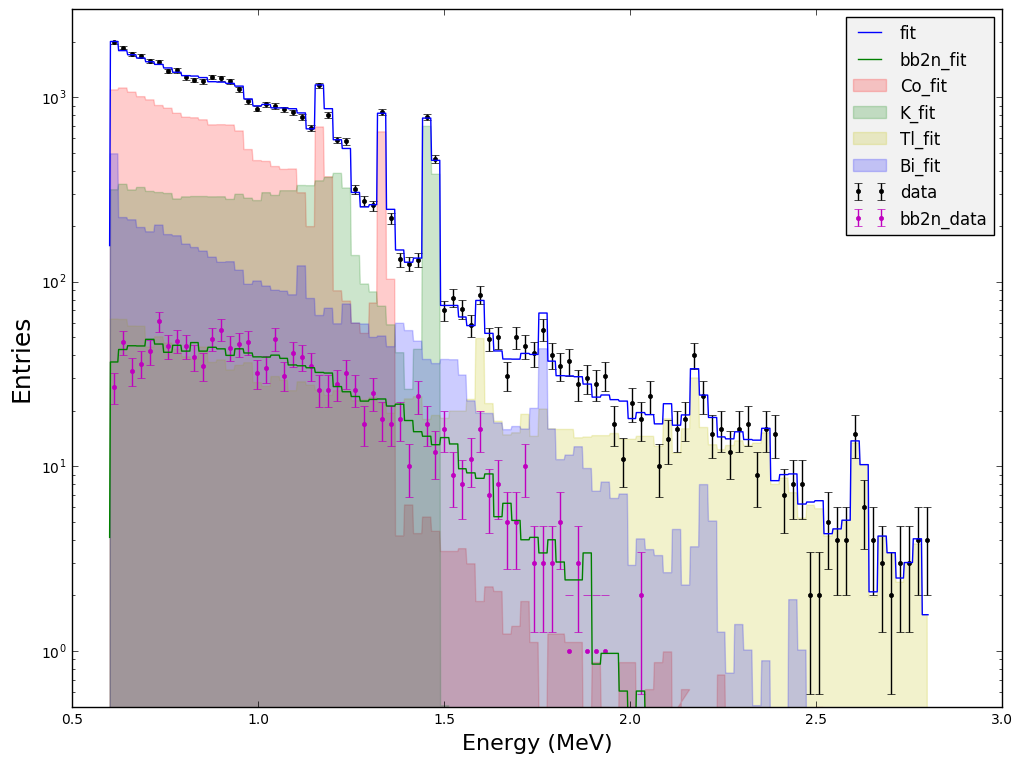

In [199]:
alfa= 0.2
plt.semilogy()
plt.ylim(0.5,3e3)
plt.errorbar(Ea,totala,yerr=np.sqrt(totala),marker='.',elinewidth=1,
             linewidth=0,label='data',color='black')
plt.errorbar(Ea,testnna,yerr=np.sqrt(testnna),marker='.',elinewidth=1,
             linewidth=0,label='bb2n_data',color='m')
plt.plot(Ep,fittotal,label='fit')
plt.plot(Ep,y_bb2nP,label='bb2n_fit')
plt.fill_between(Ep,0,y_CoP,label='Co_fit',alpha=alfa,color='r')
plt.fill_between(Ep,0,y_KP,label='K_fit',alpha=alfa,color='g')
plt.fill_between(Ep,0,y_TlP,label='Tl_fit',alpha=alfa,color='y')
plt.fill_between(Ep,0,y_BiP,label='Bi_fit',alpha=alfa,color='b')
#plt.plot(E)
plt.gcf().set_size_inches(12,9)
plt.legend().get_frame().set_facecolor('0.95')
plt.xlabel('Energy (MeV)',fontsize=16)
plt.ylabel('Entries',fontsize=18)
plt.savefig('fitspectrum.pdf')

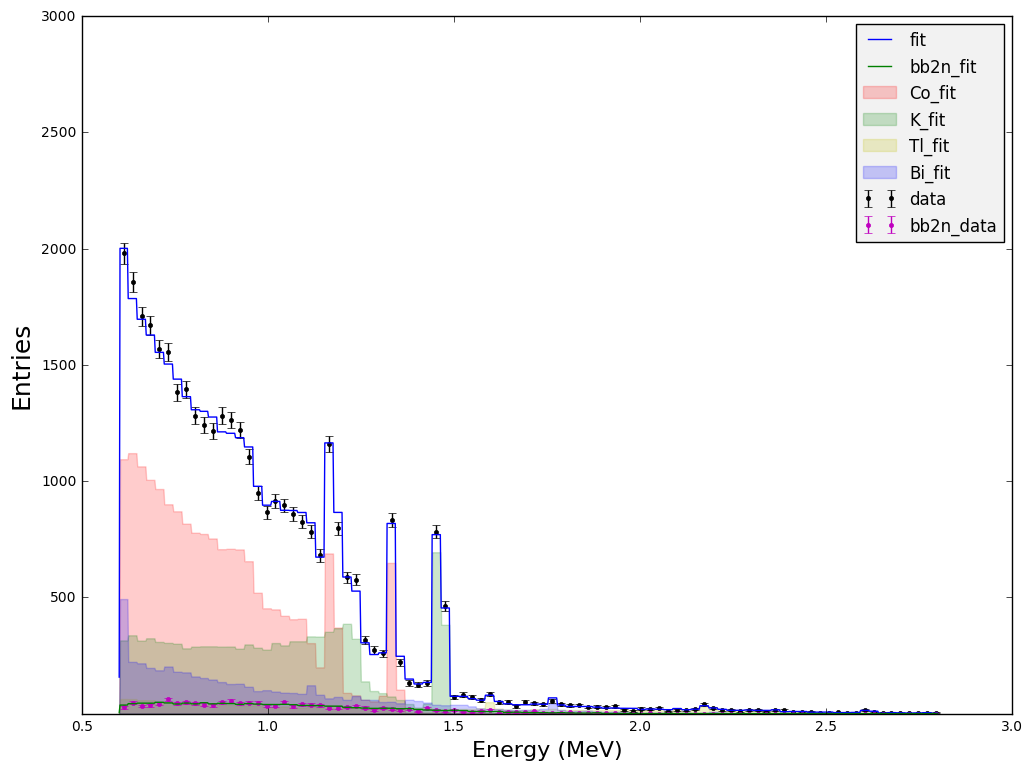

In [195]:
alfa= 0.2
#plt.semilogy()
plt.ylim(0.5,3e3)
plt.errorbar(Ea,totala,yerr=np.sqrt(totala),marker='.',elinewidth=1,
             linewidth=0,label='data',color='black')
plt.errorbar(Ea,testnna,yerr=np.sqrt(testnna),marker='.',elinewidth=1,
             linewidth=0,label='bb2n_data',color='m')
plt.plot(Ep,fittotal,label='fit')
plt.plot(Ep,y_bb2nP,label='bb2n_fit')
plt.fill_between(Ep,0,y_CoP,label='Co_fit',alpha=alfa,color='r')
plt.fill_between(Ep,0,y_KP,label='K_fit',alpha=alfa,color='g')
plt.fill_between(Ep,0,y_TlP,label='Tl_fit',alpha=alfa,color='y')
plt.fill_between(Ep,0,y_BiP,label='Bi_fit',alpha=alfa,color='b')
#plt.plot(E)
plt.gcf().set_size_inches(12,9)
plt.legend().get_frame().set_facecolor('0.95')
plt.xlabel('Energy (MeV)',fontsize=16)
plt.ylabel('Entries',fontsize=18)
plt.savefig('fitspectrum.pdf')

In [196]:
total.sum()

36653.0

In [197]:
result.sum()

36652.896547500008